In [1]:
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.models import Sequential
from keras import backend as K
from keras.callbacks import TensorBoard
from keras.optimizers import SGD

import numpy as np
import os
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [4]:
#data input
FTRAIN = 'Data/training.csv'
FTEST = 'Data/test.csv'
def load(test=False, cols=None):
    fname = FTEST if test else FTRAIN
    df = pd.read_csv(os.path.expanduser(fname))
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))

    if cols:
        df = df[list(cols)+['Image']]
    
    #print(df.count())
    df = df.dropna()
    
    X = np.vstack(df['Image'].values)/255
    X = X.astype(np.float32) 
    X = X.reshape(-1,96,96,1)
    
    if(not test):
        y = df[df.columns[:-1]].values
        y = (y-48)/48
        y = y.astype(np.float32)
    else:
        y = None           
    
    return X, y

X, y = load()

In [10]:
#neural net
model = Sequential()
model.add(Conv2D(32, (3, 3),padding='valid', input_shape=(96, 96, 1))) #96 x 96 x 1
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.1))
    
model.add(Conv2D(64, (3, 3))) #48 x 48 x 32
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))    
model.add(Dropout(0.1))

model.add(Conv2D(128, (3, 3))) #24 x 24 x 64
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))    
model.add(Dropout(0.1))

model.add(Conv2D(128, (3,3))) #12 x 12 x 128
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.1))

model.add(Conv2D(128, (3,3))) #6 x 6 x 128
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.1))

# 3 x 3 x 256
    
model.add(Flatten())
model.add(Dense(800))
model.add(Activation('relu'))
model.add(Dropout(0.4))

model.add(Dense(800))
model.add(Activation('relu'))
model.add(Dropout(0.4))

model.add(Dense(600))
model.add(Activation('relu'))
model.add(Dropout(0.4))

model.add(Dense(400))
model.add(Activation('relu'))
model.add(Dropout(0.4))

model.add(Dense(30)) #linear activation

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 94, 94, 32)        320       
_________________________________________________________________
activation_16 (Activation)   (None, 94, 94, 32)        0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 47, 47, 32)        0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 45, 45, 64)        18496     
_________________________________________________________________
activation_17 (Activation)   (None, 45, 45, 64)        0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 22, 22, 64)        0         
__________

In [40]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
model.compile(optimizer='adadelta', loss='mean_squared_error', metrics=['accuracy']) #fix loss?

In [43]:
hist = model.fit(x_train, y_train, batch_size=64, epochs=10, verbose=1, validation_data=(x_test,y_test))
#hist = model.fit(X, y, batch_size=64, epochs=5, verbose=1, validation_split=.2)

Train on 1712 samples, validate on 428 samples
Epoch 1/1
1712/1712 [==============================] - 21s - loss: 0.0056 - acc: 0.6857 - val_loss: 0.0044 - val_acc: 0.7056


Test Loss: 0.00437820331568
Test Accuracy: 0.705607476636


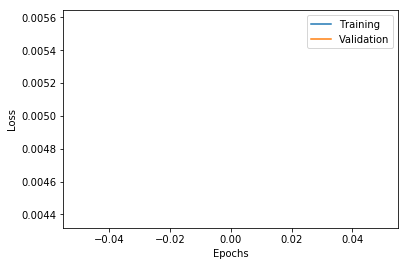

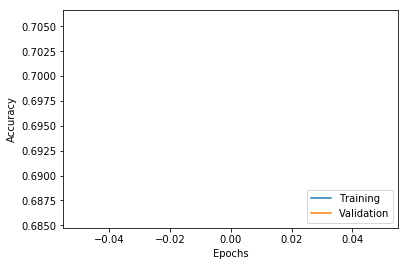

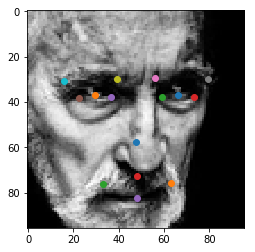

In [51]:
plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['Training', 'Validation'])

plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.legend(['Training', 'Validation'], loc='lower right')

idx = 1700
plt.figure()
locs = (model.predict(x_train[idx].reshape(1,96,96,1))*48+48)[0]
for x in range(0,30,2):
    plt.scatter(locs[x],locs[x+1])
plt.imshow(x_train[idx].reshape(96,96), cmap='gray')
           
loss, accuracy = model.evaluate(x_test, y_test, verbose=0) #update this
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)